# 필요 파일 드라이브에서 카피 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/CT분류프로젝트/Custom_Py/init.py' ./

# 데이터 디렉토리 로드 

In [1]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')

## 파일 디렉토리 설정 

In [3]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

## 이미지 디렉토리 dir_df 생성 

In [2]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['dir'])

##환자정보- snsb_df 생성 

In [3]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x)))

snsb_df = snsb_df[columns]

## 병록번호- key 값 보정

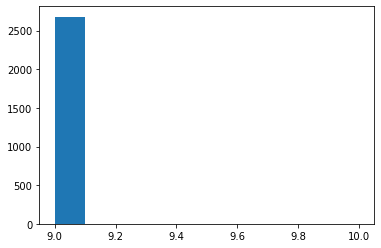

In [4]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

#병록 번호의 length 가 target_length에 속하는 것들 모두 0 더해서 9자리로 맞춤 
for length in target_length: 
  difference = 9 - length #추가해줘야 하는 자릿수 
  add = '0' *difference #추가해줘야 하는 자릿수 만큼 0추가 
  
  modified_id = snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'].apply(lambda x : add+x)
  snsb_df.loc[snsb_df['병록번호'].map(len)==length,'병록번호'] = modified_id

#위 로직으로 보정되지 않은 것들 임베딩으로 보정 아래 dict keys 값들이 보정되지 않은 값임 
mis_keys_dict = {'17043':'170435316','19021':'190215496','20004':'200045636','97026':'970266683','094018957':'940189576'}
mis_keys_keys = list(mis_keys_dict.keys())

#위 mis_keys_dict를 토대로 값 보정 진행 
temp = dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'].apply(lambda x:mis_keys_dict[x])
dir_df.loc[dir_df['key'].apply(lambda x : x in mis_keys_keys),'key'] = temp

plt.hist(snsb_df['병록번호'].map(len))
plt.show()

## Key 값 미스매칭 확인 

In [5]:
csv_key = list(set(snsb_df['병록번호']))
img_key = list(set(dir_df['key']))
csv_key.sort()
img_key.sort()
csv_key = np.array(csv_key)
img_key = np.array(img_key)

error = [] 
for i in range(len(img_key)):
  if img_key[i] in csv_key:
    pass
  else:
    error.append(i)

print(img_key[error])

['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']


# 초기 작업 - 이미지 장수 조절
- 이미지 갯수는 20개인 경우가 가장 많지만 이미지를 살리기 위해 19장으로 진행 
- 우선 19장보다 작은 경우는 모두 제하고 진행 

- 키값별로 이미지 갯수를 구하는 리스트 생성 
- 키값별 19장 indexing 
- indexing 대로 추출해서 새로운 DF에 input 

## Key 별 이미지 갯수 리스트 생성 

Key 별 이미지 장수 확인 

In [6]:
def check_images(dir_df,key):
  length = dir_df[dir_df['key']==key]['dir'].values.shape[0]
  return length

#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
images_length.value_counts()

20     1336
40      182
60       55
80       13
19       10
100       7
24        3
23        3
10        3
39        2
38        2
22        2
25        2
9         2
21        2
17        2
59        1
57        1
33        1
55        1
52        1
96        1
16        1
150       1
28        1
12        1
31        1
Name: 0, dtype: int64

images_length 데이터 프레임 생성 (key,이미지 장수)

In [7]:
length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
length_df_less = length_df[length_df['image_length']<standard]

## dir에서 추출해서 new_dir_df 생성 

In [187]:
# 제거해야 하는 사진 갯수 구하는 함수 
def return_length_diff(length_df,index):
  temp_key = length_df.iloc[index]['key']
  temp_length = length_df.iloc[index]['image_length']
  length_diff = abs(int(standard-temp_length)) #2로 아직 나누지 않음 
  return length_diff

# front_drop, rear_drop = return_drop_counts(length_df_over,0)

# 키값으로 인덱스 호출
def return_images_indexes(dir_df,length_df,index):
  temp_key = length_df['key'].values[index]
  temp_indexes = dir_df[dir_df['key'] == temp_key].index
  return temp_indexes

#키값으로 호출한 인덱스에서 필요한 장수 standard 갯수만큼 인덱스만 남김 
def droped_indexes(dir_df,length_df,index):
  temp_indexes = return_images_indexes(dir_df,length_df,index)
  length_diff = return_length_diff(length_df,index)
  indexes = temp_indexes[:-length_diff]
  return indexes

#19장 씩 dir 잘라서 보관할 새로운 빈 DF 생성  
new_dir_df = pd.DataFrame(np.zeros(1618*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

#19장씩 뽑아서 새로운 빈 DF에 넣기 
for index in tqdm(range(1618)):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[droped_indexes(dir_df,length_df_over,index)]

100%|██████████| 1618/1618 [00:13<00:00, 121.34it/s]


In [9]:
new_dir_df_1 = pd.DataFrame(np.zeros(1618*19*2).reshape(-1,2))
new_dir_df_1.columns = dir_df.columns

for index in tqdm(range(1618)):
  new_dir_df_1.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]

100%|██████████| 1618/1618 [00:16<00:00, 98.81it/s] 


length_df_over 갖고 진행 

장수 조절 되었나 확인 

In [12]:
def new_check_images(dirdf_df,key):
  length = df[df['key']==key]['dir'].values.shape[0]
  return length

#이미지 장수 확인
keys = list(set(new_dir_df['key'])) 
temp = pd.DataFrame(keys)[0].apply(lambda x: check_images(new_dir_df,x)) #키 값별로 이미지의 장수들 계산 
temp.value_counts()

NameError: ignored

361이 나오는 것은 아직 length_df_less가 다 들어오지 않은 것들 때문 

# 초기 작업 - z score 임베딩 생성

In [14]:
Embedding_columns = snsb_df.columns[4:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

In [15]:
#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key'])

# 데이터 로드 

## 키 리스트 생성 

new_dir_df 에 있는 키들만 따로 리스트 만들기
- 우선은 10개만 진행 

In [190]:
key_lists = np.unique(new_dir_df['key'].values)[:10]
print(len(key_lists))

10


## 이미지 로드 

In [191]:
# 이미지 확인용, 매번 치기 귀찮아서 
def path_img(path):
  plt.figure(figsize=(10,10))
  plt.imshow(cv2.imread(path))
  plt.show()

위에 뽑은 키값들로 이미지 Read 

In [192]:
#키값으로 이미지 dir 검색 
def temp_dir_df(new_dir_df,key):
  temp_df = new_dir_df[new_dir_df['key']==key]
  return temp_df

#더미 넘파이에 한개씩 넣음 -> 19개 넣어서 19,512,512,3 shape 만듬 
def read_imgs(temp_df):
  from tqdm import tqdm 
  temp_imgs = []
  for dir_index in tqdm(range(19)):
    temp_img = cv2.imread(temp_df['dir'].iloc[dir_index])
    temp_img = cv2.resize(temp_img,dsize= (512,512))
    temp_imgs.append(temp_img)
  temp_imgs = np.array(temp_imgs)
  return temp_imgs
  
# 위 두개 통합 
def make_temp_imgs(new_dir_df,key):
  temp_df = temp_dir_df(new_dir_df,key)
  temp_imgs = read_imgs(temp_df)
  return temp_imgs

In [193]:
for key_index in range(10):
  key = key_lists[key_index]
  imgs = []
  temp_imgs = make_temp_imgs(new_dir_df,key)
  imgs.append(temp_imgs)

100%|██████████| 19/19 [00:00<00:00, 189.69it/s]


## CSV 로드 

Key_lists 별로 csv 데이터 불러 오고 이미지랑 순서 맞춤 

In [194]:
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs

,성명,병록번호,만나이,검사일,교육년수,SVLT_recall_total_score_z,SVLT_Delayed_recall_z,SVLT_recognition_score_z,RCFT_immediate_recall_z,RCFT_delayed_recall_z,RCFT_recognition_score_z,K_MMSE_total_score_z,SNSB_II_Domain_Attention_z,SNSB_II_Domain_Language_z,SNSB_II_Domain_Visuospatial_z,SNSB_II_Domain_Memory_z,SNSB_II_Domain_Frontal_z,E_교육년수,E_SVLT_recall_total_score_z,E_SVLT_Delayed_recall_z,E_SVLT_recognition_score_z,E_RCFT_immediate_recall_z,E_RCFT_delayed_recall_z,E_RCFT_recognition_score_z,E_K_MMSE_total_score_z,E_SNSB_II_Domain_Attention_z,E_SNSB_II_Domain_Language_z,E_SNSB_II_Domain_Visuospatial_z,E_SNSB_II_Domain_Memory_z,E_SNSB_II_Domain_Frontal_z
2327,안복인,000004737,81,2015-02-25,0.5,0.34,-0.33,-0.32,0.48,-0.21,-1.15,-1.55,-0.79,-1.00,-1.66,-0.35,-2.04,1,1,1,1,1,1,0,0,1,1,0,1,0
162,김영미4차,000017838,56,2021-09-16,3.0,-0.30,-0.56,-0.29,-1.01,-1.26,-1.75,-1.49,-2.05,-1.69,-1.19,-1.55,0.91,1,1,1,1,0,0,0,0,0,0,0,0,1
82,유재봉2차,000021072,75,2021-11-24,6.0,-1.26,-2.09,-2.93,-1.30,-1.76,-2.63,NaN,-0.72,-1.45,-3.06,-2.88,-1.98,1,0,0,0,0,0,0,0,1,0,0,0,0
84,김갑식,000070403,78,2021-11-23,12.0,-1.07,-2.08,0.28,-1.33,-1.42,-0.89,-1.70,-1.43,-2.24,-2.00,-1.52,-2.68,1,0,0,1,0,0,1,0,0,0,0,0,0
2437,홍군자,000095896,69,2014-10-20,12.0,0.93,0.55,-0.08,-0.02,-0.17,-0.10,0.46,-0.13,-1.27,-1.13,0.28,0.61,1,1,1,1,1,1,1,1,1,0,0,1,1
2436,황수용3차,000105206,65,2014-10-21,9.0,-2.86,-1.43,-1.90,2.89,2.60,0.04,0.71,-0.82,-0.44,-1.63,-0.17,-0.86,1,0,0,0,1,1,1,1,1,1,0,1,1
1558,조양현,000122036,88,2018-03-08,0.0,1.86,0.98,0.73,0.87,0.28,0.44,0.94,0.71,-0.07,-0.02,1.07,NaN,1,1,1,1,1,1,1,1,1,1,1,1,0
2559,우주용,000137866,70,2014-04-07,6.0,-0.59,-1.43,-3.69,-1.28,-1.40,-0.14,-2.12,-0.31,-0.05,-3.17,-2.06,-4.02,1,1,0,0,0,0,1,0,1,1,0,0,0
1402,유순전,000147676,79,2018-07-18,8.0,-0.18,-2.30,-0.47,-1.97,-1.98,-2.07,-3.14,-1.64,-0.12,-1.88,-2.07,-0.72,1,1,0,1,0,0,0,0,0,1,0,0,1
745,유순전2차,000147676,80,2020-04-09,8.0,-1.27,-2.08,-1.18,-1.19,-0.90,-1.86,-5.04,-0.92,-1.66,-0.84,-1.97,-0.63,1,0,0,0,0,1,0,0,1,0,1,0,1


In [195]:
print(len(csvs))

12
